In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

plt.rcParams["figure.figsize"] = (18, 9)

In [70]:
train_path = "andan-2022-autumn-lab-4/train.csv"
test_path = "andan-2022-autumn-lab-4/test_x.csv"

In [71]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

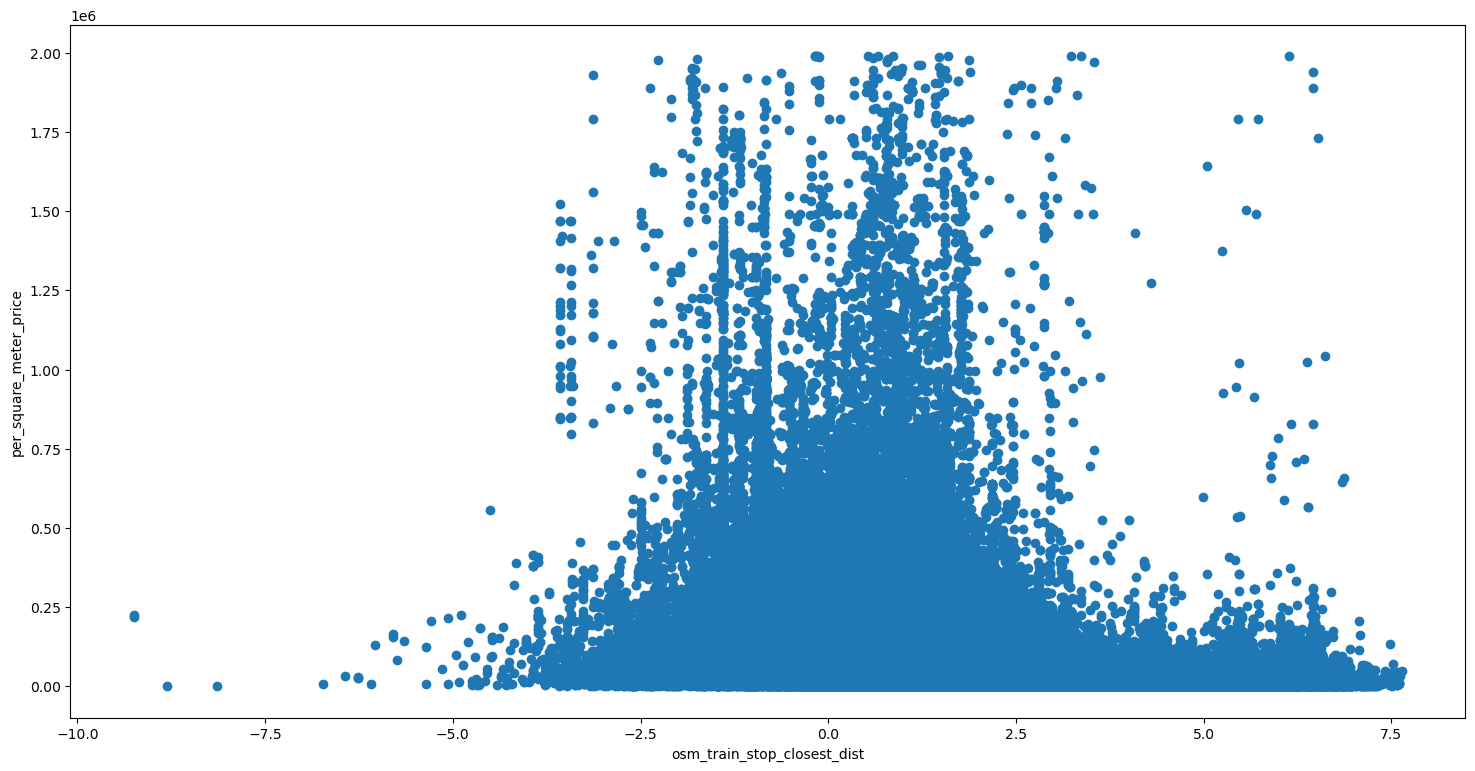

In [72]:
from math import log2

plt.scatter(train_data[train_data.osm_train_stop_closest_dist < 200]["osm_train_stop_closest_dist"].apply(log2), train_data[train_data.osm_train_stop_closest_dist < 200].per_square_meter_price )
plt.xlabel('osm_train_stop_closest_dist')
plt.ylabel('per_square_meter_price')

plt.show()



In [73]:
towns_with_metro = {
    "Москва", "Санкт-Петербург", "Новосибирск", "Екатеринбург", "Казань", "Нижний Новгород", "Самара"
}

params = [
    "total_square",
    "osm_train_stop_closest_dist",
    "osm_subway_closest_dist",
    "city",
]
new_params = [
    "is_msk",
    "is_spb"
]

# FIXME переделать под заранее определенные min и max
def minmax(col, _min, _max):

    col[col < _min] = 0
    col[_max < col] = 1
    # from sklearn.preprocessing import minmax_scale
    # col[(_min < col) & (col < _max)] = minmax_scale(col[(_min < col) & (col < _max)], copy=False)
    col[(_min < col) & (col < _max)] = (col[(_min < col) & (col < _max)] - _min) / (_max - _min)
    return col

def city_handler(s):
    return [
        1 if s in towns_with_metro else 0, # metro in city
        1 if s == "Москва" else 0,
        1 if s == "Санкт-Петербург" else 0,
    ]

def line_handler(line):
    ma = []
    for name in params:
        if name in [
                    # 'city',
                    ]: # ignore
            continue
        elif name in ['city']:
            ma += city_handler(line[name])
        else:
            ma += [line[name]]
    return ma

def getRegression(data):

    data = data[params]

    # data = data.assign(
        # rewrite
        # total_square=minmax(data["total_square"], 0),
        # osm_train_stop_closest_dist=minmax(data["osm_train_stop_closest_dist"], 0, 200),
        # osm_subway_closest_dist=minmax(data["osm_subway_closest_dist"], 0, 2000),
        # new
        # is_msk=np.where((data['city'] == "Москва"), 1, 0),
        # is_spb=np.where((data['city'] == "Санкт-Петербург"), 1, 0),
        # is_city_mil_nearby=np.where((data['osm_city_nearest_population'] > 1e6), 1, 0),
        # osm_city_closest_dist=minmax(data["osm_city_closest_dist"]),
    # )

    # data = data[params + new_params]

    X = []
    for i in data.index:
        line = data.iloc[i]
        X += [line_handler(line)]
        # print(X)

    # print(X[0])
    X = np.array(X)
    # print(X[0])
    return X

In [74]:
reg = LinearRegression(copy_X=False, n_jobs=-1)

In [75]:
train_data_original = pd.read_csv(train_path)
train_data = train_data_original.copy()

In [76]:
X, per_square_meter_price = getRegression(train_data), train_data['per_square_meter_price']

In [77]:
X_with_org_original = list(zip(X, list(per_square_meter_price)))

In [78]:
errors = []
def pred(X, per_square_meter_price, test, rating_pred, reg):
    reg.fit(X, per_square_meter_price)
    prc = reg.predict(test)
    errors.append(mean_absolute_percentage_error(rating_pred, prc))
    print(errors[-1])

for i in range(10):
    import random
    X_with_org = X_with_org_original.copy()
    random.shuffle(X_with_org)
    train_comb = X_with_org[int(len(X_with_org)*0.8):]
    test_comb = X_with_org[:int(len(X_with_org)*0.8)]
    X, per_square_meter_price = zip(*train_comb)
    test, rating_pred = zip(*test_comb)

    pred(X, per_square_meter_price, test, rating_pred, reg)

print("Mean:", sum(errors)/len(errors))
# 1) 3.08928935118498
# 2) add start/end to dists
# 2.990469893742038
# 3) remove city
# 3.9515472764739865

# 5) without minmax
# 2.535033998987495

2.5690442377886513
2.5193571173063423
2.549908015732166
2.527162957247203
2.5026197779643202
2.5576965455848506
2.543834047224606
2.5077383112560705
2.55274748488975
2.5202314948809934
Mean: 2.535033998987495


### Отсюда пойдут предсказания

In [79]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [80]:
X, per_square_meter_price = getRegression(train_data), train_data['per_square_meter_price']

In [81]:

reg.fit(X, per_square_meter_price)

LinearRegression(copy_X=False, n_jobs=-1)

In [82]:
X_test = getRegression(test_data)

In [83]:
ma = reg.predict(X_test)

In [84]:
from itertools import count
rating_pred = pd.DataFrame(zip(np.array(ma), count(0)), columns=['per_square_meter_price', 'id'])
rating_pred.to_csv('andan-2022-autumn-lab-4/saved_submission_4lab.csv', index=False)
print(rating_pred)

       per_square_meter_price     id
0               267291.726193      0
1                56180.965387      1
2                55954.309042      2
3                59889.532538      3
4                48379.185353      4
...                       ...    ...
68820            53983.578198  68820
68821            57395.002867  68821
68822            57197.910844  68822
68823           302130.049422  68823
68824            57326.154885  68824

[68825 rows x 2 columns]
